# Run the network with specific weight parameters

In [1]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.generateFrames as gf
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

# Specific for the HDDM study
#import hddm

# Save/load datatables functions

In [3]:
# directory = the filepath to where you want to save your data.  
#   You could use directory="" to save it in the same directory 
#   you are running the notebook in.

# foldername = a name for a new folder to put this specific data set in.
#   The code will create this folder for you.  
#   Whenever you have a new data set, you need to use a new foldername, 
#   otherwise it will overwrite the older results.

def saveData(paramtable,datatables,directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable.to_pickle(file_name,protocol=0)
    for i in range(len(datatables)):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables[i].to_pickle(file_name,protocol=0)
        
def loadData(directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable = pd.read_pickle(file_name)
    filecount = len([f for f in os.listdir(targetfolder) 
                     if os.path.isfile(os.path.join(targetfolder, f)) 
                     and f.startswith("data") and f.endswith(".pkl")])
    datatables = []
    for i in range(filecount):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables.append(pd.read_pickle(file_name))
    return (paramtable,datatables)

# Global Parameters:

In [4]:
# Working directory
parentDir = 'dftest'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [5]:
BaseStim = 0
Stim = 2.54
Dynamic = 50.0 #30
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [6]:
def get_sampling_params2(scale=.05, values=[0.018,0.018,0.018,0.018,
                                            0.0986,0.0986,0.0986,0.0986,
                                            0.28,1.1,0.28,1.65,0.35,0.018,0.0114,0.117,
                                            0.255,0.255,0.03,0.132,0.07,1.51,0.03,1.75]):
    
    Cx_dMSN_NMDA_L = values[0] #0.063
    Cx_dMSN_NMDA_R = values[1] #0.063
    Cx_iMSN_NMDA_L = values[2] #0.063
    Cx_iMSN_NMDA_R = values[3] #0.063
    
    Cx_dMSN_AMPA_L = values[4] #0.1286
    Cx_dMSN_AMPA_R = values[5] #0.1286
    Cx_iMSN_AMPA_L = values[6] #0.1286
    Cx_iMSN_AMPA_R = values[7] #0.1286
    
    dMSN_iMSN = values[8] #0.28
    D1STR_GPi = values[9] #1.10
    
    iMSN_dMSN  = values[10] #0.28
    D2STR_GPeP = values[11] #1.65
    
    GPe_STN = values[12] #0.4
    GPe_GPi = values[13] #0.012
    
    STN_GPi    = values[14] #0.0324
    
    GPi_Th     =  values[15] #0.067
    
    Th_STRd = values[16] #0.255
    Th_STRi = values[17] #0.255
    
    
    
    CxTh       =    values[18] #0.03
    CxFSI      =    values[19] #0.132
    STN_GPeP_A =    values[20] #0.07
    STN_GPeP_N =    values[21] #4.01
    ThCx       =    values[22] #0.02
    
    GPeP_GPeP  =    values[23] #1.5 
    
    STN_GPeP = [STN_GPeP_A, STN_GPeP_N] # [AMPA, NMDA]
    
    CxSTRd = (Cx_dMSN_NMDA_L+Cx_dMSN_NMDA_R)/2.0
    CxSTRi = (Cx_iMSN_NMDA_L+Cx_iMSN_NMDA_R)/2.0
    
    preset = ng.set_post_learning_weights(dMSN=[Cx_dMSN_NMDA_L/CxSTRd, Cx_dMSN_NMDA_R/CxSTRd],
                                          iMSN=[Cx_iMSN_NMDA_L/CxSTRi, Cx_iMSN_NMDA_R/CxSTRi])
    
    preset[0]['D1STR_0_0'] = {'dpmn_w':Cx_dMSN_AMPA_L}
    preset[0]['D1STR_1_0'] = {'dpmn_w':Cx_dMSN_AMPA_R}
    preset[0]['D2STR_0_0'] = {'dpmn_w':Cx_iMSN_AMPA_L}
    preset[0]['D2STR_1_0'] = {'dpmn_w':Cx_iMSN_AMPA_R}
    
    #print(preset)

    
    mu = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi, 'GPeP': STN_GPeP},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi, 'GPeP': GPeP_GPeP})

    # PROVISIONAL
    sd = dict(Cx={'STRd':CxSTRd, 'STRi':CxSTRi, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STRd':Th_STRd, 'STRi':Th_STRi, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi, 'D2STR': dMSN_iMSN},
                D2STR={'GPeP': D2STR_GPeP, 'D1STR_syn': iMSN_dMSN},
                STN={'GPi': STN_GPi, 'GPeP': STN_GPeP},
                GPi={'Th': GPi_Th},
                GPeP={'STN': GPe_STN, 'GPi': GPe_GPi, 'GPeP': GPeP_GPeP})
    
    for x in list(sd):
        for y in sd[x]:
            sd[x][y]=0
    sd['STN']['GPeP']=[0,0]
    
    #sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd, preset

# Phenotypes - find boundaries (connections 1 by 1)

In [8]:
import statistics
NumSteps=1  #number of steps
eps=1e-3    #discretization size

N_subj = 1
sdScale = .0 # variablity on the efficacy values.
conProb = ng.getConProb()

cores=4
np.random.seed(seed=np.random.randint(0,1000))

# set stimulus strength
stim = 2.5

# number of simulation we would like to run
totalSim = 1 #250

for ns in range(0,NumSteps):
    #value= 0.255*(0.25+0.375*ns)
    #value= 1.3+1.0*ns
    value = 0.113
    values=[0.018,0.018,0.018,0.018,
            0.0986,0.0986,0.0986,0.0986,
            0.28, 1.1, 0.28,1.65, 0.35, 0.018,0.0114,0.117,
            0.255,0.255,0.03,0.132,0.07,1.51,0.03,1.75]

    varIter=75
    print('Step',ns,' with value', value)
    
    # define parameters
    muEff, sdEff, preset = get_sampling_params2(sdScale,values)
    X = sample_network_efficacies(muEff, sdEff, N=N_subj)
    subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]
    
    # get conn. efficacies for 1st subject network (idx=0)
    idx = 0
    conEff_i = subj_eff_dicts[idx]

    # configure trial and network parameters
    sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,totalSim)),
                               d1aw=[0], # Changes the alpha_w for D1
                               d2aw=[0], # Changes the alpha_w for D2
                               rewardprob=[1.0], # It's overwritten inside the netgen.
                               dpmn_ratio=0.,   # it doesn't do anything
                               dpmn_implied=0.,  # it doesn't do anything
                               SustainedFraction = 0.75
                              )
    sweepcount
    
    # run the simulation
    ng.compileAndRunSweepALL_Onofre(1,0,sweepcount,cores)
    
    results = ng.readAllTrialResults(1,0,totalSim,['popfreqs'])
    decisions = []
    for sn in range(totalSim):
        decisions.append([])
        for result in results[sn]:
            decisions[sn].append(ng.findOutputs2(result)['decision made'])
                
    # Change the None values in decisions' list for 0's
    for xdec in decisions[0][0]:
        if xdec['delay']==None:
            xdec['delay']=0.0
    
    (paramtable,datatables) = gf.generateFrames(results,decisions)
#    foldername="Prova"
#    saveData(paramtable,datatables,"",foldername)
    
    d1=datatables[0].decision #[0:50]
    # REMOVE 'None' values from d
    d=[]
    for val in d1: 
        if val != None: 
            d.append(val) 
    RightPercent=(sum(d)/len(d))*100  # d contains 0=action is given; 1=action is NON given
    

    #Check Reaction Times (RT) in [75,300]
    dd=datatables[0].decisionduration
    if max(dd) >= 300: # to be correct, the action decision time must be smaller than 300ms
        print('The value', value, 'causes a reaction time greater than the expected')
    if min(dd) <= 75: # to be correct, the action decision time must be greater than 75ms
        print('The value', value, 'causes a reaction time smaller than the expected')
    print(value, '&', min(dd), '&', max(dd),'&', statistics.mean(dd), '&', RightPercent, '\% \\')

    #Check Firing Rates in [0,MAX]
    if max(result['popfreqs'].D1STR_0_0[100:])>40 or max(result['popfreqs'].D1STR_1_0[100:])>40 or max(result['popfreqs'].D2STR_0_0[100:])>40 or max(result['popfreqs'].D2STR_1_0[100:])>40 or max(result['popfreqs'].GPeP_0_0[100:])>150 or max(result['popfreqs'].GPeP_1_0[100:])>150 or max(result['popfreqs'].GPi_0_0[100:])>150 or max(result['popfreqs'].GPi_1_0[100:])>150 or max(result['popfreqs'].STNE_0_0[100:])>53 or max(result['popfreqs'].STNE_1_0[100:])>53 or max(result['popfreqs'].Th_0_0[100:])>85 or max(result['popfreqs'].Th_1_0[100:])>85 or max(result['popfreqs'].LIP_0_0[100:])>100 or max(result['popfreqs'].LIP_1_0[100:])>100 or max(result['popfreqs'].FSI_0[100:])>70:
        print('The value', value, 'causes firing rates greater than the expected')
        print('dMSN_0', max(result['popfreqs'].D1STR_0_0[100:]))
        print('dMSN_1',max(result['popfreqs'].D1STR_1_0[100:]))
        print('iMSN_0',max(result['popfreqs'].D2STR_0_0[100:]))
        print('iMSN_1',max(result['popfreqs'].D2STR_1_0[100:]))
        print('GPe_0',max(result['popfreqs'].GPeP_0_0[100:]))
        print('GPe_1',max(result['popfreqs'].GPeP_1_0[100:]))
        print('GPi_0',max(result['popfreqs'].GPi_0_0[100:]))
        print('GPi_1',max(result['popfreqs'].GPi_1_0[100:]))
        print('STN_0',max(result['popfreqs'].STNE_0_0[100:]))
        print('STN_1',max(result['popfreqs'].STNE_1_0[100:]))
        print('Th_0',max(result['popfreqs'].Th_0_0[100:]))
        print('Th_1',max(result['popfreqs'].Th_1_0[100:]))
        print('Cx_0',max(result['popfreqs'].LIP_0_0[100:]))
        print('Cx_1',max(result['popfreqs'].LIP_1_0[100:]))
        print('FSI',max(result['popfreqs'].FSI_0[100:]))

    #Check Baselines in specific boundaries
    if sum(result['popfreqs'].D1STR_0_0[100:600])/500.0>5 or sum(result['popfreqs'].D1STR_1_0[100:600])/500.0>5 or sum(result['popfreqs'].D2STR_0_0[100:600])/500.0>5 or sum(result['popfreqs'].D2STR_1_0[100:600])/500.0>5 or sum(result['popfreqs'].GPeP_0_0[100:600])/500.0<40 or sum(result['popfreqs'].GPeP_1_0[100:600])/500.0<40 or sum(result['popfreqs'].GPeP_0_0[100:600])/500.0>90 or sum(result['popfreqs'].GPeP_1_0[100:600])/500.0>90 or sum(result['popfreqs'].GPi_0_0[100:600])/500.0<40 or sum(result['popfreqs'].GPi_1_0[100:600])/500.0<40 or sum(result['popfreqs'].GPi_0_0[100:600])/500.0>90 or sum(result['popfreqs'].GPi_1_0[100:600])/500.0>90 or sum(result['popfreqs'].STNE_0_0[100:600])/500.0<10 or sum(result['popfreqs'].STNE_1_0[100:600])/500.0<10 or sum(result['popfreqs'].STNE_0_0[100:600])/500.0>35 or sum(result['popfreqs'].STNE_1_0[100:600])/500.0>35 or sum(result['popfreqs'].Th_0_0[100:600])/500.0<4 or sum(result['popfreqs'].Th_1_0[100:600])/500.0<4 or sum(result['popfreqs'].Th_0_0[100:600])/500.0>20 or sum(result['popfreqs'].Th_1_0[100:600])/500.0>20 or sum(result['popfreqs'].FSI_0[100:600])/500.0<5 or sum(result['popfreqs'].FSI_0[100:600])/500.0>40:
        print('The value', value, 'causes baselines out of range')

Step 0  with value 0.113
Waiting for subprocess to end
Done
0.113 & 80.33203125 & 112.96875 & 94.29911458333333 & 51.66666666666667 \% \
The value 0.113 causes firing rates greater than the expected
dMSN_0 47.99999237060547
dMSN_1 46.66655731201172
iMSN_0 50.666534423828125
iMSN_1 49.3332405090332
GPe_0 110.93486785888672
GPe_1 109.19855499267578
GPi_0 122.66708374023438
GPi_1 121.33198547363281
STN_0 54.93442153930664
STN_1 56.002384185791016
Th_0 89.3332748413086
Th_1 83.99935150146484
Cx_0 54.901912689208984
Cx_1 58.33329391479492
FSI 34.666141510009766


Text(0.5, 8.5, 'reaction time')

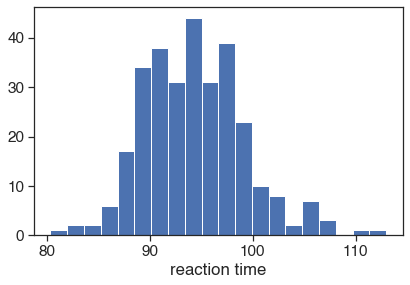

In [54]:
# Histogram
fig = plt.figure()
plt.hist(datatables[0].decisionduration[0:500],20)
plt.tight_layout()
plt.xlabel("reaction time")
#fig.savefig('Threshold50-hist-lessThSTRd.png', dpi=500)

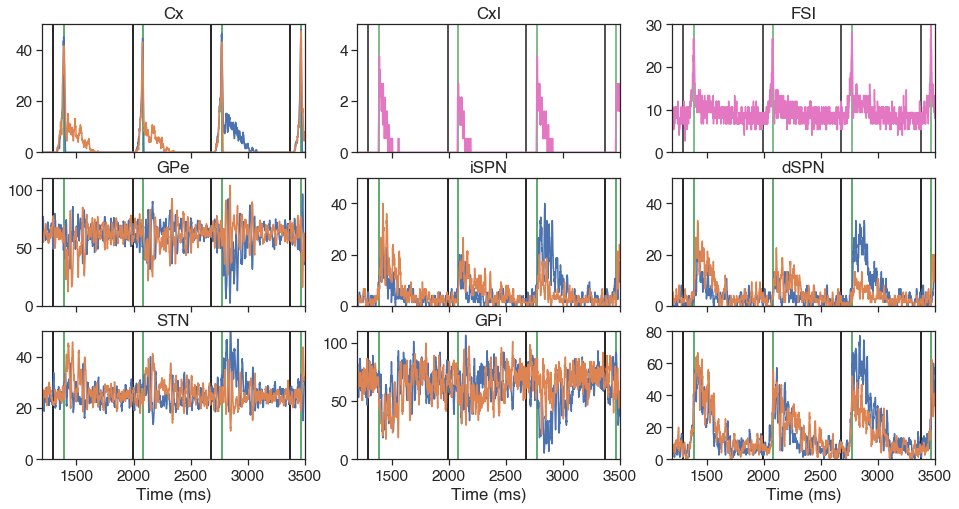

In [53]:
# Plot Population firing rates
results = ng.readAllTrialResults(8,0,sweepcount,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs'])
result = results[0][0]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
 
    result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax2[0],legend=None)
    ax2[0].vlines(datatables[0].stimulusstarttime,0,110,'k')
    ax2[0].vlines(datatables[0].decisiontime,0,110,'g')
    ax2[0].title.set_text('GPe') #legend(['GPe_A','GPe_B'])
    # ax1[1].vlines(datatables[0].rewardtime,0,100,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2[1],legend=None)
    ax2[1].vlines(datatables[0].stimulusstarttime,0,50,'k')
    ax2[1].vlines(datatables[0].decisiontime,0,50,'g')
    ax2[1].title.set_text('iSPN') #legend(['iSPN_A','iSPN_B'])
    # ax2[0].vlines(datatables[0].rewardtime,0,30,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0',ax=ax2[2],legend=None)
    ax2[2].vlines(datatables[0].stimulusstarttime,0,50,'k')
    ax2[2].vlines(datatables[0].decisiontime,0,50,'g')
    ax2[2].title.set_text('dSPN') #legend(['dSPN_A','dSPN_B'])
    # ax1[0].vlines(datatables[0].rewardtime,0,30,'r')

    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax3[0],legend=None)
    ax3[0].vlines(datatables[0].stimulusstarttime,0,50,'k')
    ax3[0].vlines(datatables[0].decisiontime,0,50,'g')
    ax3[0].title.set_text('STN') #legend(['STN_A','STN_B'])
    # ax2[1].vlines(datatables[0].rewardtime,0,50,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax3[1],legend=None)
    ax3[1].vlines(datatables[0].stimulusstarttime,0,110,'k')
    ax3[1].vlines(datatables[0].decisiontime,0,110,'g')
    ax3[1].title.set_text('GPi') #legend(['GPi_A','GPi_B'])
    # ax1[2].vlines(datatables[0].rewardtime,0,100,'r')    

    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax3[2],legend=None)
    ax3[2].vlines(datatables[0].stimulusstarttime,0,80,'k')
    ax3[2].vlines(datatables[0].decisiontime,0,80,'g')
    ax3[2].title.set_text('Th') #legend(['Th_A','Th_B'])
    # ax2[2].vlines(datatables[0].rewardtime,0,70,'r')
    
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax1[0],legend=None)
    ax1[0].vlines(datatables[0].stimulusstarttime,0,50,'k')
    ax1[0].vlines(datatables[0].decisiontime,0,50,'g')
    ax1[0].title.set_text('Cx') #legend(['Cx_A','Cx_B'])
    # ax3[0].vlines(datatables[0].rewardtime,0,75,'r')
    
result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax1[1],color='tab:pink',legend=None)
ax1[1].vlines(datatables[0].stimulusstarttime,0,5,'k')
ax1[1].vlines(datatables[0].decisiontime,0,5,'g')
ax1[1].title.set_text('CxI') #legend(['CxI'])
    
result['popfreqs'].plot(x='Time (ms)', y='FSI'+'_0', ax=ax1[2],color='tab:pink',legend=None)
ax1[2].vlines(datatables[0].stimulusstarttime,0,30,'k')
ax1[2].vlines(datatables[0].decisiontime,0,30,'g')
ax1[2].title.set_text('FSI') #legend(['FSI'])
    # ax3[2].vlines(datatables[0].rewardtime,0,60,'r')

for ax, axx, axxx in zip(ax1, ax2, ax3):
    ax.set_xlim(200, ax.get_xlim()[-1])#(750,900)#
    axx.set_xlim(200, axx.get_xlim()[-1])#(750,900)#
    axxx.set_xlim(200, axxx.get_xlim()[-1])#(750,900)#

    ax.set_xlim(1200,3500)#
    axx.set_xlim(1200,3500)#
    axxx.set_xlim(1200,3500)#

    #ax.set_xlim(1200,1800)#
    #axx.set_xlim(1200,1800)#
    #axxx.set_xlim(1200,1800)#


ax1[0].set_ylim(0,50)
ax1[1].set_ylim(0,5)
ax1[2].set_ylim(0,30)

ax2[0].set_ylim(0,110)
ax2[1].set_ylim(0,50)
ax2[2].set_ylim(0,50)

ax3[0].set_ylim(0,50)
ax3[1].set_ylim(0,110)
ax3[2].set_ylim(0,80)



plt.savefig('ActualFR.png', dpi=400)

### FR mean over trials

In [26]:
import statistics
ratedf = result['popfreqs']
keysInicials=[]
keysFinals=[]


#find the initial key of each trial
for j in datatables[0].stimulusstarttime:
    i=0
    noTrobat=0
    while noTrobat==0 and i<len(ratedf['Time (ms)']):
        if ratedf['Time (ms)'][i]<j:
            i=i+1
        else: 
            noTrobat=1    
    keysInicials.append(i)

    
#find the final key of each trial
for j in datatables[0].decisiontime:
    i=0
    noTrobat=0
    while noTrobat==0 and i<len(ratedf['Time (ms)']):
        if ratedf['Time (ms)'][i]<j:
            i=i+1
        else: 
            noTrobat=1    
    keysFinals.append(i-1)     
        
#find the length of the largest trial
dif=[]
for i in range(0,len(keysInicials)):
    dif.append(keysFinals[i]-keysInicials[i])

L=max(dif)
        
#become all datatables of the same length

Mean_newDic={}
Std_newDic={}
for BGregion in ratedf:
    S=[]
    for i in range(0,len(keysInicials)):
        region_i=ratedf[keysInicials[i]:keysFinals[i]].to_dict()
        region_i=list(region_i[BGregion].values())
        li=len(region_i)
        j=1
        while j<=L-li:
            region_i=[-1]+region_i
            j=j+1
        S.append(region_i)
    mean_t=[]
    std_t=[]
    for i in range(0,L):
        new_list=[]
        for ll in S:
            if ll[i]!= -1:
                new_list.append(ll[i])
        if len(new_list)>1:
            mean_t.append(statistics.mean(new_list)) #sum(new_list)/len(new_list))
            std_t.append(statistics.stdev(new_list))
    
    Mean_newDic[BGregion]=mean_t
    Std_newDic[BGregion]=std_t

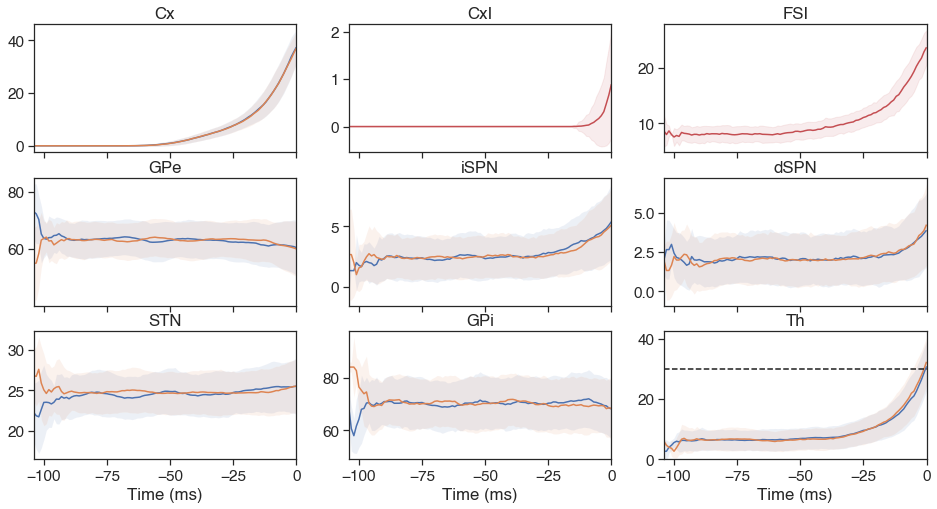

In [60]:
f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)

i=0
tmean=[]
while i<len(Mean_newDic['LIP_0_0']):
    tmean.append(i-len(Mean_newDic['LIP_0_0'])+4)
    i=i+1

ax1[0].plot(tmean[0:-3],Mean_newDic['LIP_0_0'][0:-3])
ax1[0].fill_between(tmean[0:-3],np.subtract(Mean_newDic['LIP_0_0'][0:-3],Std_newDic['LIP_0_0'][0:-3]),np.add(Mean_newDic['LIP_0_0'][0:-3],Std_newDic['LIP_0_0'][0:-3]),alpha=.1)
ax1[0].plot(tmean[0:-3],Mean_newDic['LIP_1_0'][0:-3])
ax1[0].fill_between(tmean[0:-3],np.subtract(Mean_newDic['LIP_1_0'][0:-3],Std_newDic['LIP_1_0'][0:-3]),np.add(Mean_newDic['LIP_1_0'][0:-3],Std_newDic['LIP_1_0'][0:-3]),alpha=.1)
ax1[0].title.set_text('Cx') #legend(['Cx_A','Cx_B'])
#ax1[0].plot([0,0],[0,max(Mean_newDic['LIP_0_0'])+max(Std_newDic['LIP_0_0'])],color='k',linestyle='dotted')

ax1[1].plot(tmean[0:-3],Mean_newDic['LIPI_0'][0:-3], color='r')
ax1[1].fill_between(tmean[0:-3],np.subtract(Mean_newDic['LIPI_0'][0:-3],Std_newDic['LIPI_0'][0:-3]),np.add(Mean_newDic['LIPI_0'][0:-3],Std_newDic['LIPI_0'][0:-3]),color='r',alpha=.1)
ax1[1].title.set_text('CxI') #legend(['CxI'])
#ax1[1].plot([0,0],[0,max(Mean_newDic['LIPI_0'])+max(Std_newDic['LIPI_0'])],color='k',linestyle='dotted')

ax1[2].plot(tmean[0:-3],Mean_newDic['FSI_0'][0:-3], color='r')
ax1[2].fill_between(tmean[0:-3],np.subtract(Mean_newDic['FSI_0'][0:-3],Std_newDic['FSI_0'][0:-3]),np.add(Mean_newDic['FSI_0'][0:-3],Std_newDic['FSI_0'][0:-3]),color='r',alpha=.1)
ax1[2].title.set_text('FSI') #legend(['FSI'])
#ax1[2].plot([0,0],[0,max(Mean_newDic['FSI_0'])+max(Std_newDic['FSI_0'])],color='k',linestyle='dotted')

ax2[0].plot(tmean[0:-3],Mean_newDic['GPeP_0_0'][0:-3])
ax2[0].fill_between(tmean[0:-3],np.subtract(Mean_newDic['GPeP_0_0'][0:-3],Std_newDic['GPeP_0_0'][0:-3]),np.add(Mean_newDic['GPeP_0_0'][0:-3],Std_newDic['GPeP_0_0'][0:-3]),alpha=.1)
ax2[0].plot(tmean[0:-3],Mean_newDic['GPeP_1_0'][0:-3])
ax2[0].fill_between(tmean[0:-3],np.subtract(Mean_newDic['GPeP_1_0'][0:-3],Std_newDic['GPeP_1_0'][0:-3]),np.add(Mean_newDic['GPeP_1_0'][0:-3],Std_newDic['GPeP_1_0'][0:-3]),alpha=.1)
ax2[0].title.set_text('GPe') #legend(['GPe_A','GPe_B'])
#ax2[0].plot([0,0],[0,max(Mean_newDic['GPeP_0_0'])+max(Std_newDic['GPeP_0_0'])],color='k',linestyle='dotted')

ax2[1].plot(tmean[0:-3],Mean_newDic['D2STR_0_0'][0:-3])
ax2[1].fill_between(tmean[0:-3],np.subtract(Mean_newDic['D2STR_0_0'][0:-3],Std_newDic['D2STR_0_0'][0:-3]),np.add(Mean_newDic['D2STR_0_0'][0:-3],Std_newDic['D2STR_0_0'][0:-3]),alpha=.1)
ax2[1].plot(tmean[0:-3],Mean_newDic['D2STR_1_0'][0:-3])
ax2[1].fill_between(tmean[0:-3],np.subtract(Mean_newDic['D2STR_1_0'][0:-3],Std_newDic['D2STR_1_0'][0:-3]),np.add(Mean_newDic['D2STR_1_0'][0:-3],Std_newDic['D2STR_1_0'][0:-3]),alpha=.1)
ax2[1].title.set_text('iSPN') #legend(['iSPN_A','iSPN_B'])
#ax2[1].plot([0,0],[0,max(Mean_newDic['D2STR_0_0'])+max(Std_newDic['D2STR_0_0'])],color='k',linestyle='dotted')

ax2[2].plot(tmean[0:-3],Mean_newDic['D1STR_0_0'][0:-3])
ax2[2].fill_between(tmean[0:-3],np.subtract(Mean_newDic['D1STR_0_0'][0:-3],Std_newDic['D1STR_0_0'][0:-3]),np.add(Mean_newDic['D1STR_0_0'][0:-3],Std_newDic['D1STR_0_0'][0:-3]),alpha=.1)
ax2[2].plot(tmean[0:-3],Mean_newDic['D1STR_1_0'][0:-3])
ax2[2].fill_between(tmean[0:-3],np.subtract(Mean_newDic['D1STR_1_0'][0:-3],Std_newDic['D1STR_1_0'][0:-3]),np.add(Mean_newDic['D1STR_1_0'][0:-3],Std_newDic['D1STR_1_0'][0:-3]),alpha=.1)
ax2[2].title.set_text('dSPN') #legend(['dSPN_A','dSPN_B'])
#ax2[2].plot([0,0],[0,max(Mean_newDic['D1STR_1_0'])+max(Std_newDic['D1STR_0_0'])],color='k',linestyle='dotted')

   
ax3[0].plot(tmean[0:-3],Mean_newDic['STNE_0_0'][0:-3])
ax3[0].fill_between(tmean[0:-3],np.subtract(Mean_newDic['STNE_0_0'][0:-3],Std_newDic['STNE_0_0'][0:-3]),np.add(Mean_newDic['STNE_0_0'][0:-3],Std_newDic['STNE_0_0'][0:-3]),alpha=.1)
ax3[0].plot(tmean[0:-3],Mean_newDic['STNE_1_0'][0:-3])
ax3[0].fill_between(tmean[0:-3],np.subtract(Mean_newDic['STNE_1_0'][0:-3],Std_newDic['STNE_1_0'][0:-3]),np.add(Mean_newDic['STNE_1_0'][0:-3],Std_newDic['STNE_1_0'][0:-3]),alpha=.1)
ax3[0].title.set_text('STN') #legend(['STN_A','STN_B'])
ax3[0].set_xlabel('Time (ms)')
#ax3[0].plot([0,0],[0,max(Mean_newDic['STNE_0_0'])+max(Std_newDic['STNE_0_0'])],color='k',linestyle='dotted')

ax3[1].plot(tmean[0:-3],Mean_newDic['GPi_0_0'][0:-3])
ax3[1].fill_between(tmean[0:-3],np.subtract(Mean_newDic['GPi_0_0'][0:-3],Std_newDic['GPi_0_0'][0:-3]),np.add(Mean_newDic['GPi_0_0'][0:-3],Std_newDic['GPi_0_0'][0:-3]),alpha=.1)
ax3[1].plot(tmean[0:-3],Mean_newDic['GPi_1_0'][0:-3])
ax3[1].fill_between(tmean[0:-3],np.subtract(Mean_newDic['GPi_1_0'][0:-3],Std_newDic['GPi_1_0'][0:-3]),np.add(Mean_newDic['GPi_1_0'][0:-3],Std_newDic['GPi_1_0'][0:-3]),alpha=.1)
ax3[1].title.set_text('GPi') #legend(['GPi_A','GPi_B'])
ax3[1].set_xlabel('Time (ms)')
#ax3[1].plot([0,0],[0,max(Mean_newDic['GPi_0_0'])+max(Std_newDic['GPi_0_0'])],color='k',linestyle='dotted')

ax3[2].plot(tmean[0:-3],Mean_newDic['Th_0_0'][0:-3])
ax3[2].fill_between(tmean[0:-3],np.subtract(Mean_newDic['Th_0_0'][0:-3],Std_newDic['Th_0_0'][0:-3]),np.add(Mean_newDic['Th_0_0'][0:-3],Std_newDic['Th_0_0'][0:-3]),alpha=.1)
ax3[2].plot(tmean[0:-3],Mean_newDic['Th_1_0'][0:-3])
ax3[2].fill_between(tmean[0:-3],np.subtract(Mean_newDic['Th_1_0'][0:-3],Std_newDic['Th_1_0'][0:-3]),np.add(Mean_newDic['Th_1_0'][0:-3],Std_newDic['Th_1_0'][0:-3]),alpha=.1)
ax3[2].plot([-104, 0],[30, 30],linestyle='dashed',color='k')
ax3[2].title.set_text('Th') #legend(['Th_A','Th_B'])
ax3[2].set_xlabel('Time (ms)')
#ax3[2].plot([0,0],[0,max(Mean_newDic['Th_0_0'])+max(Std_newDic['Th_0_0'])],color='k',linestyle='dotted')
    
plt.xlim(-104,0)
plt.ylim(bottom=0)

plt.savefig('meanFR_trials2-Noline.png', dpi=400)